## Importing Necessary Libraries
This cell imports essential libraries for data handling, visualization, and model training.

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
import collections

import pywt
from scipy import stats

# from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.optimizers import Adam 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from sklearn.preprocessing import StandardScaler


%matplotlib inline

# ECG Signal Classification

This notebook focuses on merging and preprocessing three ECG datasets for the purpose of binary classification (Normal vs Abnormal). The datasets used in this project include:

---

## *Datasets*

### 1. [MIT-BIH Normal Sinus Rhythm Database](https://www.physionet.org/content/nsrdb/1.0.0/)
- *Description:* Contains normal sinus rhythm ECG signals.  
- *Sampling Frequency:* 128 Hz.  
- *Leads:* ECG1 and ECG2.  
- *Files:*
  - .atr → Annotation file.  
  - .dat → Information about the beats.  
  - .header → Metadata of the file record.

---

### 2. [MIT-BIH Supraventricular Arrhythmia Database](https://physionet.org/content/svdb/1.0.0/)
- *Description:* Contains supraventricular arrhythmia ECG signals.  
- *Sampling Frequency:* 128 Hz.  
- *Leads:* ECG1 and ECG2.  
- *Files:*
  - .atr → Annotation file.  
  - .dat → Information about the beats.  
  - .header → Metadata of the file record.

---

### 3. [ECG5000 Dataset](https://www.timeseriesclassification.com/description.php?Dataset=ECG5000)
- *Description:* A smaller dataset for ECG classification.  
- *Sampling Frequency:* 140 Hz.  
- *Leads:* ECG1.

---

## *Preprocessing*
To prepare the datasets for binary classification, the following steps are performed:
1. *Resampling:*  
   - All three datasets are resampled to a common sampling frequency of *125 Hz*.  
   - Only the *ECG1 lead* is considered.

2. *Class Balancing:*  
   - Datasets 1, 2, and 3 contain multiple classes.  
   - Multiple abnormal classes are grouped into a single *Abnormal* class, while the rest are labeled as *Normal*, ensuring a balanced dataset.

---

## *Objective*
The merged dataset will be used to train a binary classification model with the following labels:
- *Normal*
- *Abnormal*

This preprocessing ensures that the data is uniform, balanced, and ready for further analysis or modeling. Stay tuned for data visualization, feature extraction, and model training in the upcoming sections!

In [2]:
# Loading the merged dataset
data = pd.read_csv('/kaggle/input/ecgsignal/ECGSignal_Data.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-0.135,-0.115,-0.105,-0.105,-0.115,-0.115,-0.115,-0.105,-0.105,-0.135,...,0.075,0.035,-0.025,-0.055,-0.075,-0.115,-0.135,-0.135,-0.135,0
1,-0.105,-0.095,-0.085,-0.095,-0.095,-0.105,-0.085,-0.095,-0.095,-0.105,...,0.025,-0.025,-0.055,-0.105,-0.145,-0.155,-0.165,-0.165,-0.185,0
2,-0.105,-0.115,-0.125,-0.105,-0.115,-0.105,-0.105,-0.095,-0.095,-0.105,...,0.065,0.005,-0.045,-0.075,-0.105,-0.115,-0.115,-0.135,-0.125,0
3,-0.075,-0.075,-0.085,-0.075,-0.075,-0.075,-0.065,-0.075,-0.065,-0.065,...,0.085,0.035,-0.005,-0.065,-0.055,-0.095,-0.095,-0.105,-0.125,0
4,-0.065,-0.085,-0.075,-0.065,-0.075,-0.045,-0.055,-0.075,-0.065,-0.065,...,0.085,0.015,-0.045,-0.085,-0.135,-0.135,-0.155,-0.155,-0.165,0


### Selecting Features from the Dataset
This cell extracts relevant features for ECG classification.

In [3]:
X = data.iloc[:, :-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,-0.135,-0.115,-0.105,-0.105,-0.115,-0.115,-0.115,-0.105,-0.105,-0.135,...,0.175,0.075,0.035,-0.025,-0.055,-0.075,-0.115,-0.135,-0.135,-0.135
1,-0.105,-0.095,-0.085,-0.095,-0.095,-0.105,-0.085,-0.095,-0.095,-0.105,...,0.095,0.025,-0.025,-0.055,-0.105,-0.145,-0.155,-0.165,-0.165,-0.185
2,-0.105,-0.115,-0.125,-0.105,-0.115,-0.105,-0.105,-0.095,-0.095,-0.105,...,0.135,0.065,0.005,-0.045,-0.075,-0.105,-0.115,-0.115,-0.135,-0.125
3,-0.075,-0.075,-0.085,-0.075,-0.075,-0.075,-0.065,-0.075,-0.065,-0.065,...,0.165,0.085,0.035,-0.005,-0.065,-0.055,-0.095,-0.095,-0.105,-0.125
4,-0.065,-0.085,-0.075,-0.065,-0.075,-0.045,-0.055,-0.075,-0.065,-0.065,...,0.155,0.085,0.015,-0.045,-0.085,-0.135,-0.135,-0.155,-0.155,-0.165


### Visualizing Normal ECG Beats

This cell plots **four sample ECG beats** from the dataset to analyze the normal heart activity. The process involves:

1. **Setting up the Plot**  
   - We define `num_beats = 4`, meaning four beats will be visualized.  
   - A figure with `4 rows × 1 column` is created using `plt.subplots()`.  
   - The figure size is set to `(30, 20)` for better clarity.  

2. **Looping Through Beats**  
   - The first four beats from the dataset are selected using `X.iloc[i, :]`.  
   - Each beat is plotted on a separate subplot with a **blue line** and `linewidth=1.5`.  
   - Titles are added dynamically (`ECG Signal - Beat {i+1}`) for clarity.  
   - The x-axis labels are removed to avoid clutter.  
   - The y-axis is labeled **Amplitude**, representing ECG signal strength.  

3. **Final Adjustments and Saving**  
   - A common **x-axis label ("Samples")** is added.  
   - The plot is saved as `Normal beat plot.png` for reference.  
   - `plt.tight_layout()` ensures no overlap between subplots.  
   - `plt.show()` displays the final plot.  

This visualization helps in understanding **the waveform of normal ECG beats**, which can be compared with abnormal beats for classification.  


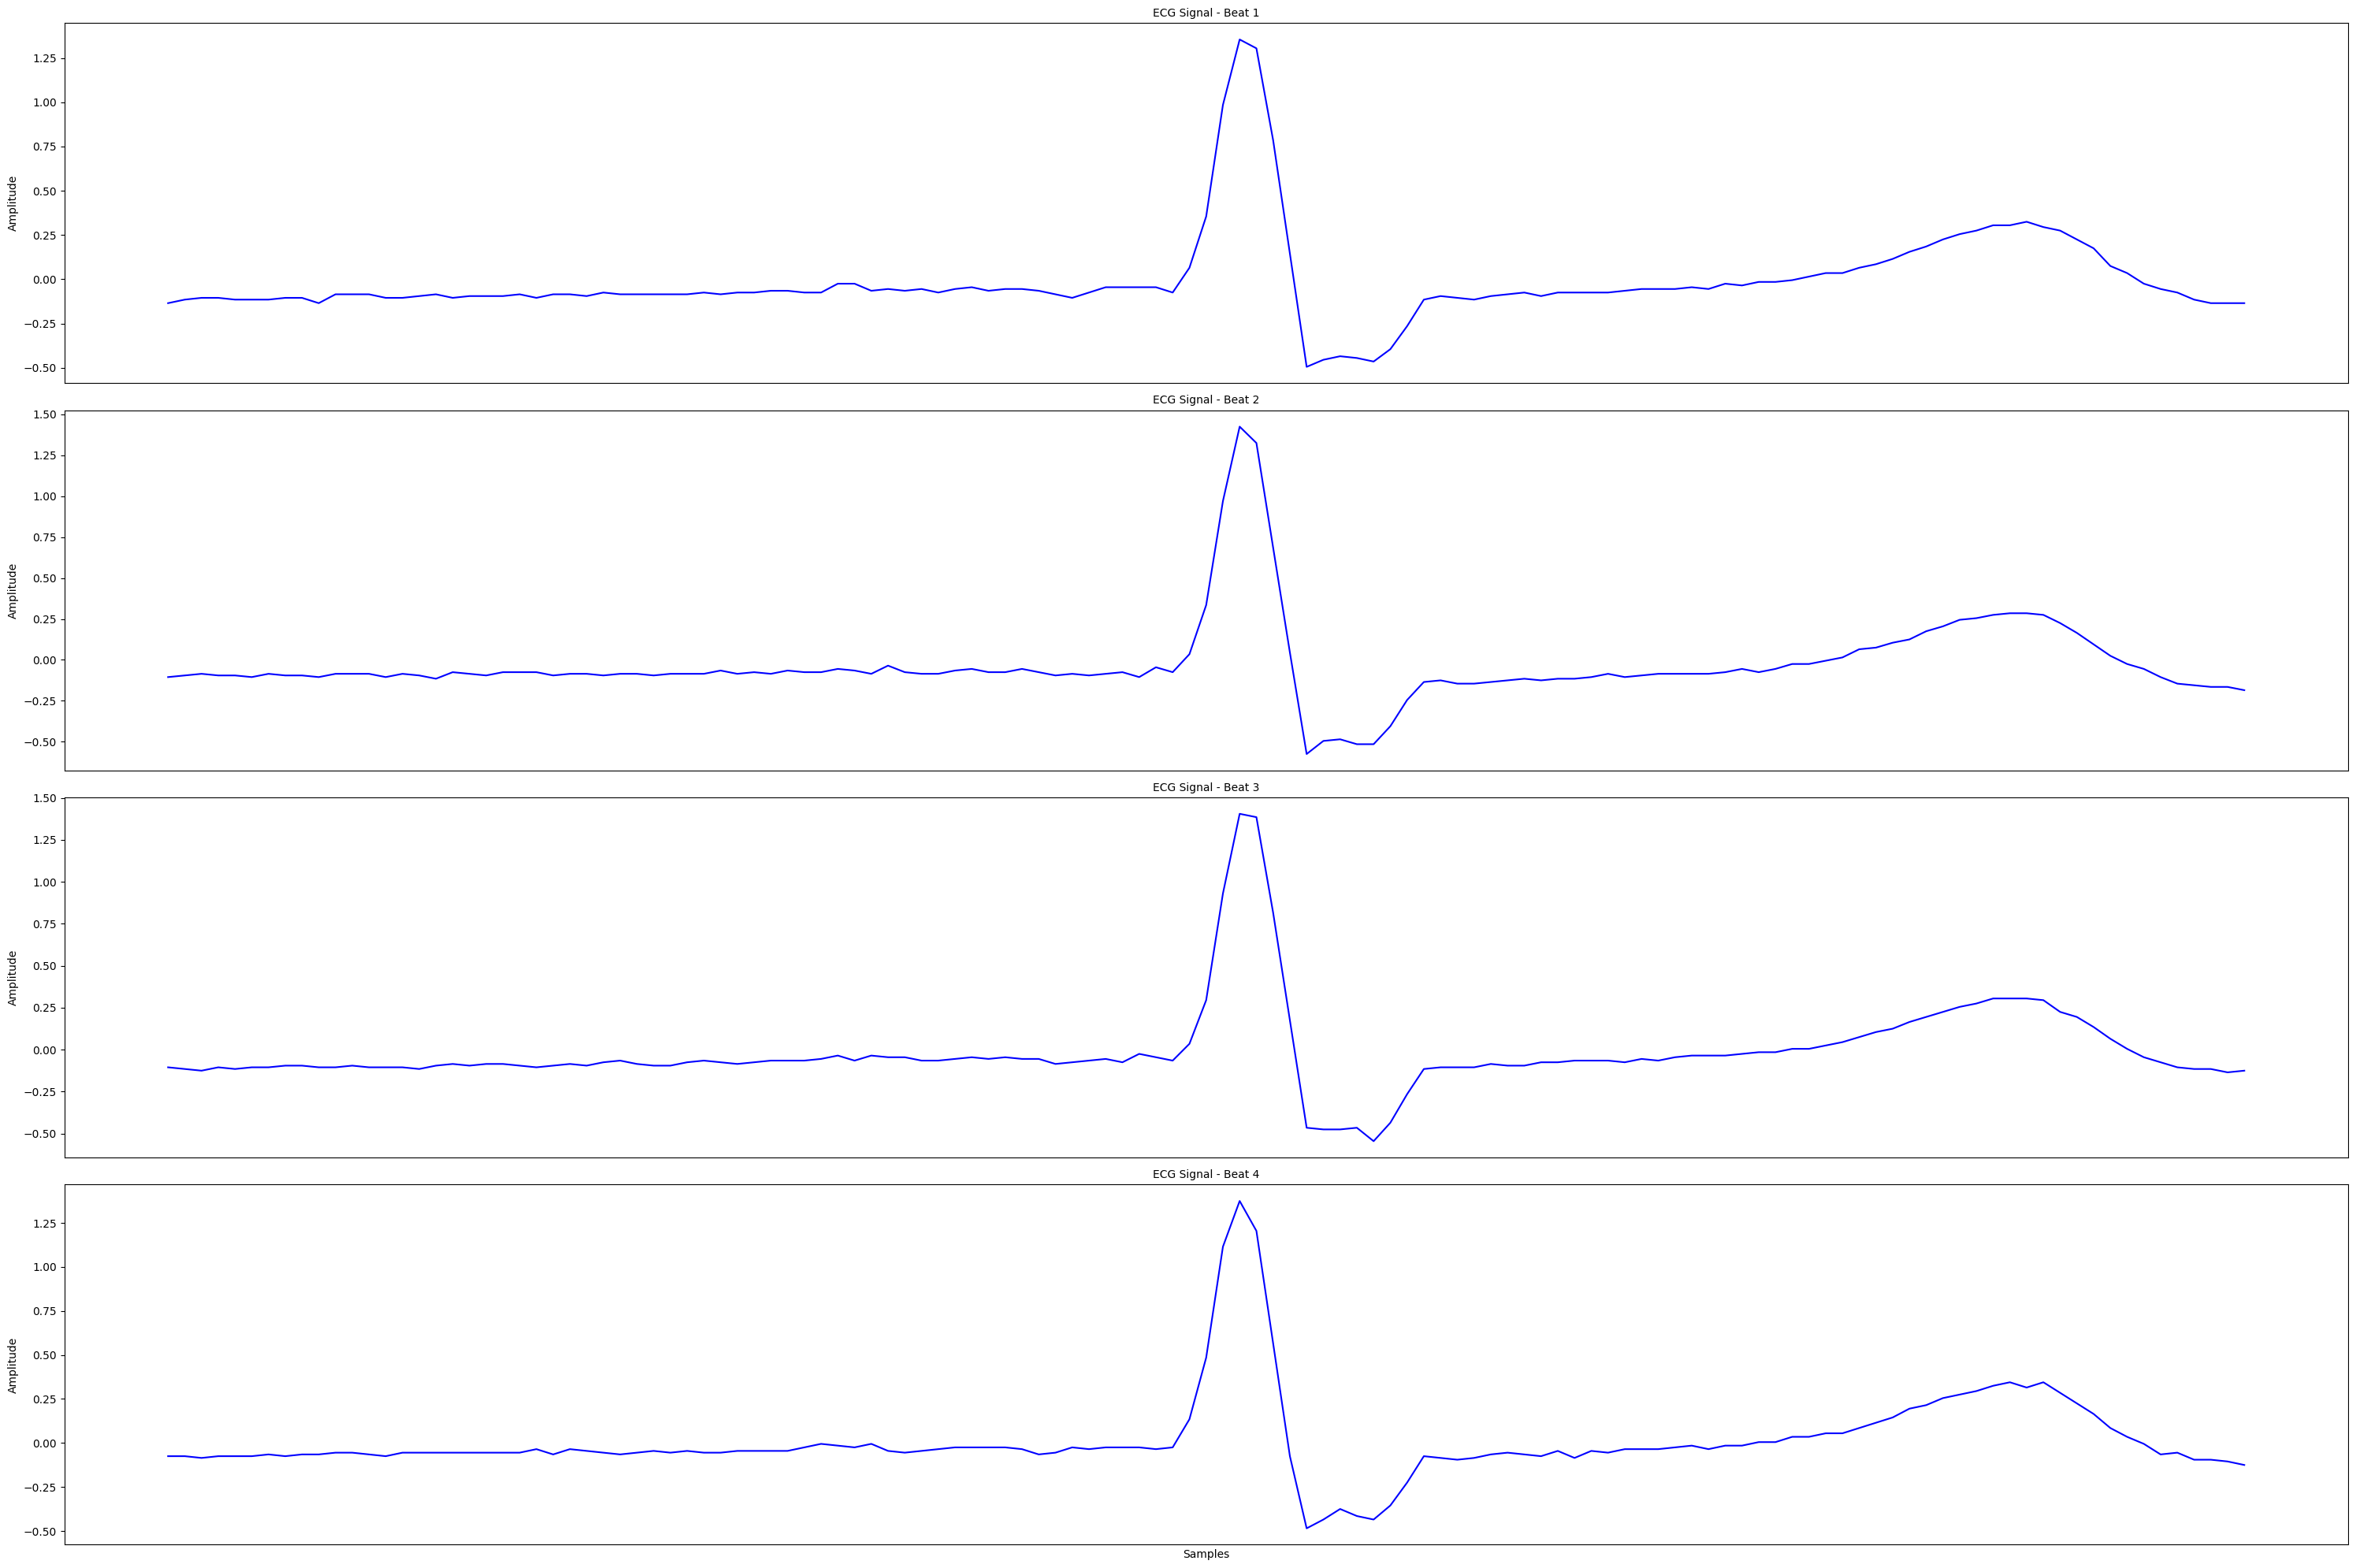

In [4]:
# Plotting the normal beats
num_beats = 4  
fig, axes = plt.subplots(num_beats, 1, figsize=(30, 20), sharex=True)

for i in range(num_beats):
    beat = X.iloc[i, :]  
    axes[i].plot(beat, color='blue', linewidth=1.5)
    axes[i].set_title(f'ECG Signal - Beat {i+1}', fontsize=10)
    axes[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-axis values
    axes[i].set_ylabel('Amplitude')

# Set a common x-axis label
plt.xlabel('Samples')
plt.savefig('Normal beat plot.png')
plt.tight_layout()
plt.show()


### Visualizing an Abnormal ECG Beat

This cell plots **a single abnormal ECG beat** from the dataset to analyze irregular heart activity. The process includes:

1. **Selecting an Abnormal Beat**  
   - The dataset contains labeled ECG signals, where the last column (`X.iloc[:, -1]`) indicates normal (0) or abnormal (1) beats.  
   - We filter the dataset to select the **first abnormal beat** using `X[X.iloc[:, -1] == 1].iloc[0, :]`.  

2. **Plotting the Abnormal Beat**  
   - A figure with a large width (`30, 5`) is created for clear visualization.  
   - The ECG beat is plotted using a **blue line** with `linewidth=1.5`.  
   - The title **"ECG Signal - Single Beat for Abnormal"** is added to highlight the beat type.  
   - The **x-axis labels are removed** to keep the focus on waveform patterns.  
   - The y-axis represents **Amplitude**, which indicates signal strength.  

3. **Final Adjustments and Saving**  
   - The x-axis is labeled **"Time (samples)"**, representing the signal duration.  
   - The plot is saved as `Abnormal_beat_plot.png` for reference.  
   - `plt.show()` displays the final visualization.  

This visualization helps in understanding **how abnormal heartbeats differ from normal ones**, which is crucial for ECG classification and diagnosis.  


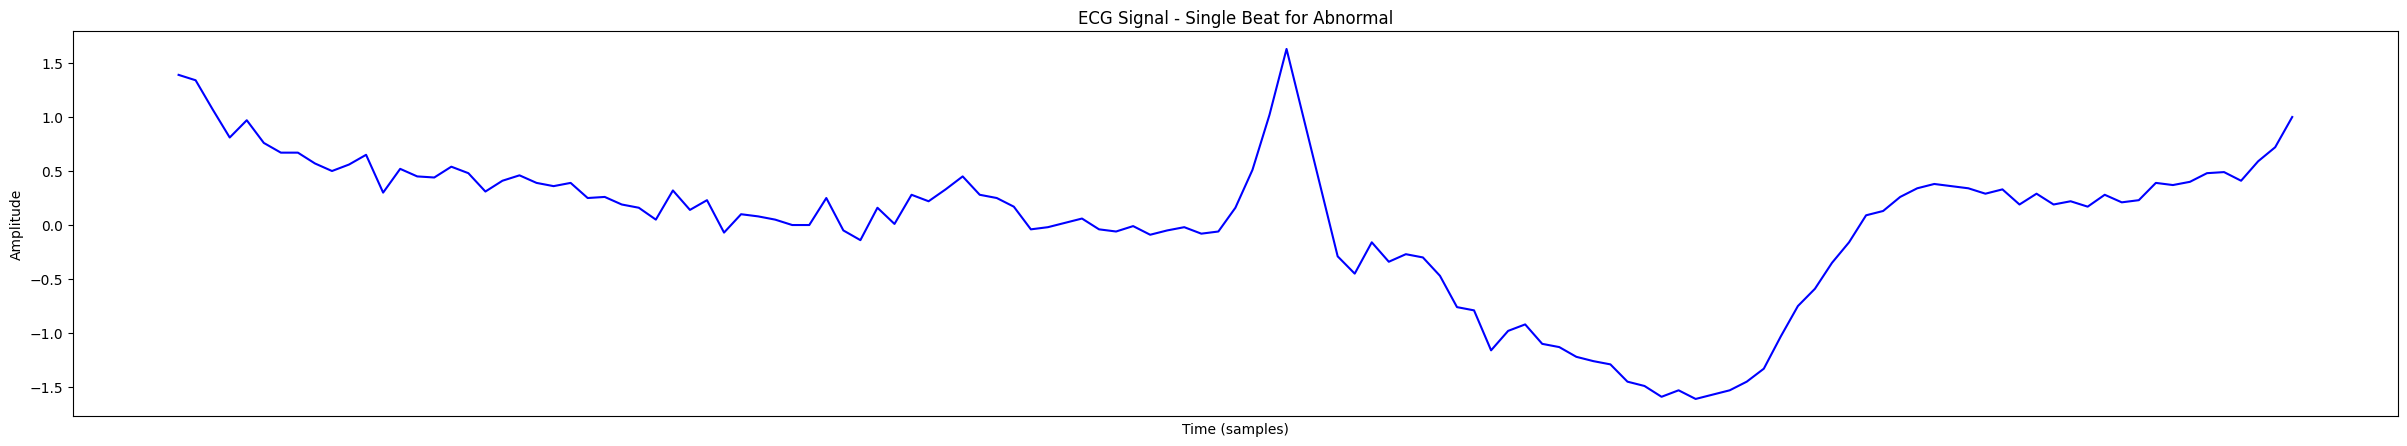

In [5]:
# plotting the abnormal beats
beat = X[X.iloc[:, -1] == 1].iloc[0, :]

plt.figure(figsize=(30, 5))
plt.plot(beat, color='blue', linewidth=1.5)
plt.title('ECG Signal - Single Beat for Abnormal')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.savefig('Abnormal_beat_plot.png')
plt.show()

### Shape of the data

In [6]:
print(f"The Shape of the data: {data.shape}")

The Shape of the data: (189459, 126)


### Visualizing Class Distribution in the ECG Dataset

This cell generates a **pie chart** to visualize the proportion of **normal vs. abnormal ECG beats** in the dataset.

#### **Steps Involved:**
1. **Counting Instances of Each Class**  
   - `data.iloc[:, -1].value_counts()` retrieves the count of **normal (0) and abnormal (1) beats** from the last column of the dataset.  
   - The result is stored in `per_classes`.  

2. **Creating the Pie Chart**  
   - A **figure of size (20,10)** is created for better visibility.  
   - The **`plt.pie()`** function is used to generate the chart:  
     - **Labels:** `['Normal', 'Abnormal']` to distinguish between classes.  
     - **Colors:** `tab:blue` for normal and `tab:orange` for abnormal beats.  
     - **Percentage Display:** `autopct='%1.1f%%'` shows the percentage of each class in the dataset.  

3. **Displaying the Chart**  
   - `plt.show()` renders the pie chart.  

#### **Purpose of This Visualization**
- Helps in understanding **class imbalance** in the dataset.  
- Provides insight into the distribution of **normal vs. abnormal heartbeats**, which is crucial for model performance and bias mitigation.  


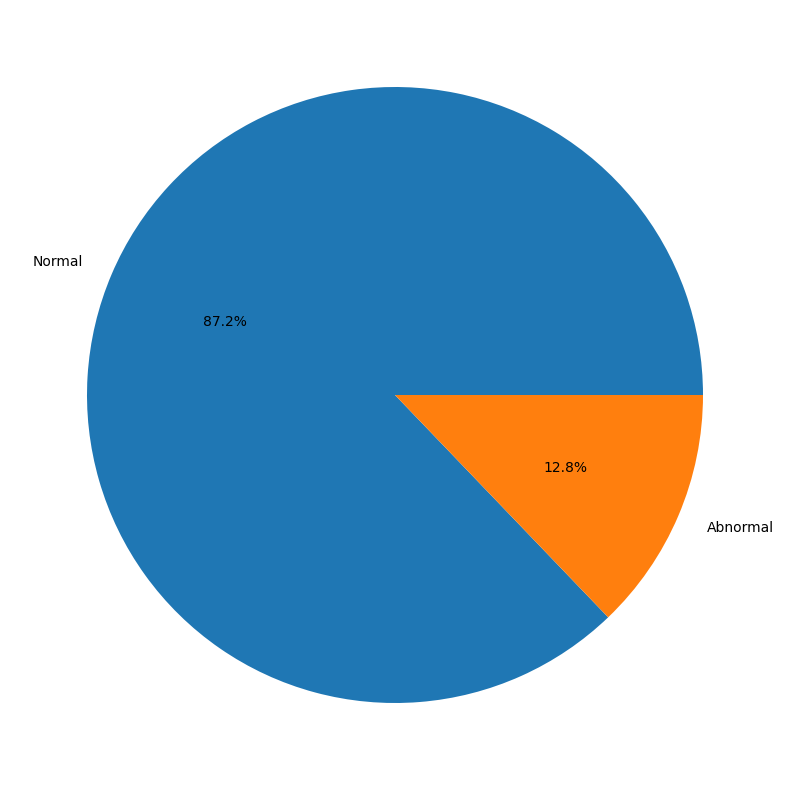

In [7]:
per_classes = data.iloc[:, -1].value_counts()
plt.figure(figsize=(20,10))
plt.pie(per_classes, labels=['Normal', 'Abnormal'], colors=['tab:blue','tab:orange'],autopct='%1.1f%%')
plt.show()

### Selecting Features and target from the Dataset
This cell extracts relevant features and target for ECG classification.

In [8]:
X = data.iloc[:, :-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,-0.135,-0.115,-0.105,-0.105,-0.115,-0.115,-0.115,-0.105,-0.105,-0.135,...,0.175,0.075,0.035,-0.025,-0.055,-0.075,-0.115,-0.135,-0.135,-0.135
1,-0.105,-0.095,-0.085,-0.095,-0.095,-0.105,-0.085,-0.095,-0.095,-0.105,...,0.095,0.025,-0.025,-0.055,-0.105,-0.145,-0.155,-0.165,-0.165,-0.185
2,-0.105,-0.115,-0.125,-0.105,-0.115,-0.105,-0.105,-0.095,-0.095,-0.105,...,0.135,0.065,0.005,-0.045,-0.075,-0.105,-0.115,-0.115,-0.135,-0.125
3,-0.075,-0.075,-0.085,-0.075,-0.075,-0.075,-0.065,-0.075,-0.065,-0.065,...,0.165,0.085,0.035,-0.005,-0.065,-0.055,-0.095,-0.095,-0.105,-0.125
4,-0.065,-0.085,-0.075,-0.065,-0.075,-0.045,-0.055,-0.075,-0.065,-0.065,...,0.155,0.085,0.015,-0.045,-0.085,-0.135,-0.135,-0.155,-0.155,-0.165


In [9]:
y = data.iloc[:, -1]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 125, dtype: int64

In [10]:
print(f"The Shape of the X: {X.shape}")
print(f"The Shape of the y: {y.shape}")

The Shape of the X: (189459, 125)
The Shape of the y: (189459,)


In [11]:
# count of the classes
y.value_counts().reset_index()

,125,count
0,0,165143
1,1,24316


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [13]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")

The shape of X_train: (151567, 125)
The shape of X_test: (37892, 125)
The length of y_train: 151567
The length of y_test: 37892


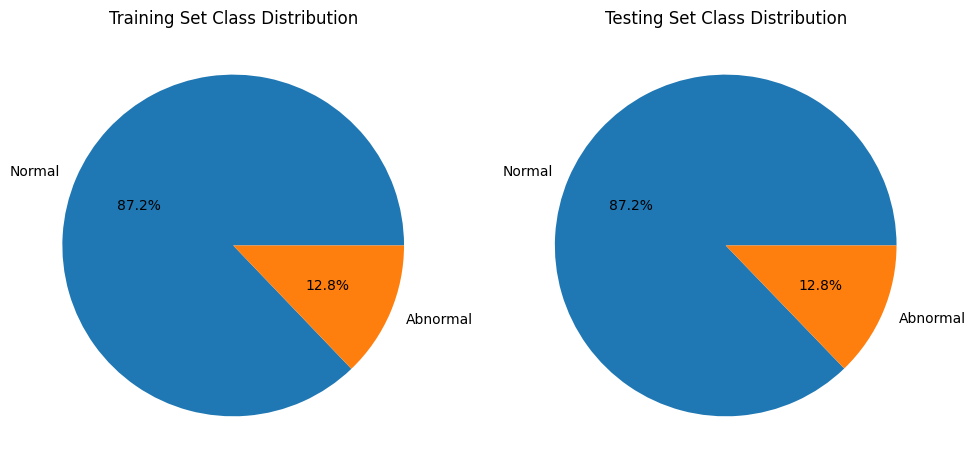

In [14]:
# Compute class distributions for training and testing sets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot the Training Set Distribution
axes[0].pie(train_counts, labels=['Normal', 'Abnormal'], colors=['tab:blue', 'tab:orange'], autopct='%1.1f%%')
axes[0].set_title('Training Set Class Distribution')

# Plot the Testing Set Distribution
axes[1].pie(test_counts, labels=['Normal', 'Abnormal'], colors=['tab:blue', 'tab:orange'], autopct='%1.1f%%')
axes[1].set_title('Testing Set Class Distribution')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


### Converting the data into NumPy arrays for feeding into the model

In [15]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))
# X_test = np.array(X_test)

# print(type(y_train))

(151567, 125, 1)
<class 'numpy.ndarray'>
(37892, 125, 1)
<class 'numpy.ndarray'>


In [16]:
print(y_train.shape)
print(y_test.shape)

(151567,)
(37892,)


### Model Architecture Definition
This section defines a **1D Convolutional Neural Network (CNN)** for ECG classification.  
The model consists of:  
- **Four Convolutional Layers** with increasing filters (`16 → 32 → 64 → 128`) to extract ECG signal features.  
- **Max Pooling Layers** to reduce spatial dimensions and computational complexity.  
- **Flattening Layer** to convert feature maps into a single vector.  
- **Fully Connected Layers** with **Dropout (0.5, 0.4, 0.3)** to prevent overfitting.  
- **Output Layer** with a **sigmoid activation** for binary classification (Normal vs. Abnormal ECG).  


In [17]:
# Function to build the CNN model for ECG classification
model = Sequential()

# First Convolutional Layer with 16 filters, kernel size 11, ReLU activation, and same padding
model.add(Conv1D(filters=16, kernel_size=11, strides=1, padding='same', activation='relu', input_shape=(125, 1)))
model.add(MaxPooling1D(pool_size=5, strides=2))  # Max pooling to reduce dimensionality

# Second Convolutional Layer with 32 filters
model.add(Conv1D(filters=32, kernel_size=13, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Third Convolutional Layer with 64 filters
model.add(Conv1D(filters=64, kernel_size=15, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Fourth Convolutional Layer with 128 filters
model.add(Conv1D(filters=128, kernel_size=17, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))  

# Flattening the feature maps into a single vector
model.add(Flatten())

# Fully connected layers with Dropout for regularization
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Display model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 125, 16)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 61, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 61, 32)              │           6,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 29, 64)              │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 13, 128)             │         139,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          64,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,257 (961.94 KB)

 Trainable params: 246,257 (961.94 KB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation
This section **compiles** the CNN model with:  
- **Loss Function:** `binary_crossentropy` (since it's a binary classification task).  
- **Optimizer:** `Adam` with a learning rate of `0.0001` for efficient learning.  
- **Metric:** `accuracy`, which evaluates how well the model is performing.  

In [18]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(
    loss='binary_crossentropy',  # Suitable for binary classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy']  # Track accuracy during training
)

### Early Stopping Mechanism
To **prevent overfitting**, `EarlyStopping` is used:  
- **Monitors Validation Loss** (`val_loss`) to track generalization.  
- **Stops Training if No Improvement in 5 Consecutive Epochs** (`patience=5`).  
- **Restores Best Weights** (`restore_best_weights=True`) to keep the most optimal model.  

In [19]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model weights after stopping
)

### Saving the Best Model in HDF5 Format

1. **Using ModelCheckpoint Callback**
   - Saves the best model based on **validation loss** (`val_loss`).
   - Ensures only the best-performing model (lowest `val_loss`) is saved.
   - The model is saved in **HDF5 format (`.h5`)**, which supports model architecture, weights, and optimizer state.

2. **Parameters in `ModelCheckpoint`**
   - `filepath='best_ecg_model.h5'` → Saves the model with this filename.
   - `monitor='val_loss'` → Tracks validation loss for saving.
   - `save_best_only=True` → Saves only the best model, preventing storage of unnecessary models.
   - `mode='min'` → Saves the model when `val_loss` decreases.

In [20]:
# Define a ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_ecg_model.keras',  # Change the extension to .keras
    monitor='val_loss',              # Monitor validation loss
    save_best_only=True,             # Save only the best model based on val_loss
    mode='min',                      # Save model when val_loss is minimized
    verbose=1                        # Print a message when saving the model
)


### Model Training Process
The model is trained on `X_train` and `y_train` using:  
- **Batch Size:** `42` (controls how many samples are processed before updating weights).  
- **Epochs:** `50` (maximum training cycles).  
- **Validation Data:** `(X_test, y_test)` for tracking model performance on unseen data.  
- **Early Stopping Callback:** Helps prevent unnecessary training when validation loss stops improving.  

In [21]:
# Train the model
history = model.fit(
    train_x, y_train,
    batch_size=42,  # Number of samples per batch
    epochs=50,  # Train for up to 50 epochs
    verbose=1,  # Show training progress
    validation_data=(test_x, y_test),  # Validate on test data
    callbacks=[early_stopping, checkpoint]  # Apply early stopping and checkpoint
)

Epoch 1/50
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9104 - loss: 0.2641
Epoch 1: val_loss improved from inf to 0.11381, saving model to best_ecg_model.keras
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9104 - loss: 0.2641 - val_accuracy: 0.9632 - val_loss: 0.1138
Epoch 2/50
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9639 - loss: 0.1108
Epoch 2: val_loss improved from 0.11381 to 0.08396, saving model to best_ecg_model.keras
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9639 - loss: 0.1108 - val_accuracy: 0.9737 - val_loss: 0.0840
Epoch 3/50
3590/3609 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9723 - loss: 0.0890
Epoch 3: val_loss improved from 0.08396 to 0.07934, saving model to best_ecg_model.keras
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9723 - loss: 0.0890 - val_accuracy: 0.9753 - val_loss: 0.0793
Epoch 4/50
3590/3609 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.0773
Epoch 4: val_loss improve

### Visualizing Model Loss Over Epochs

This plot helps analyze how well the model is learning by comparing:
- **Training Loss:** Measures how well the model is fitting the training data.
- **Validation Loss:** Measures how well the model generalizes to unseen data.


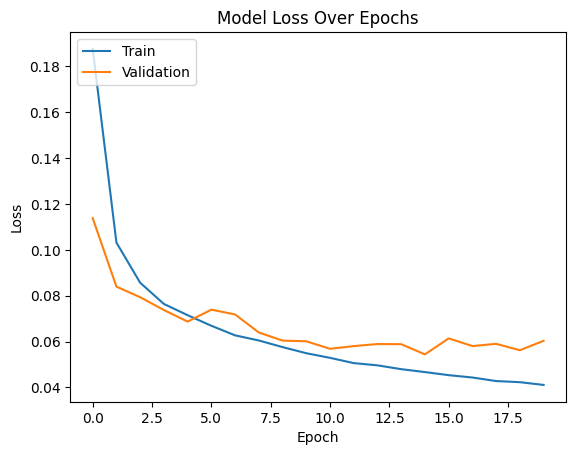

In [22]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Set the title and axis labels
plt.title('Model Loss Over Epochs')  # Title of the plot
plt.ylabel('Loss')  # Y-axis label (Loss)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation loss
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')

# Display the plot
plt.show()


### Visualizing Model Accuracy Over Epochs

This plot helps analyze the model's **learning performance** over time by comparing:
- **Training Accuracy:** How well the model is learning from the training dataset.
- **Validation Accuracy:** How well the model is generalizing to unseen data.

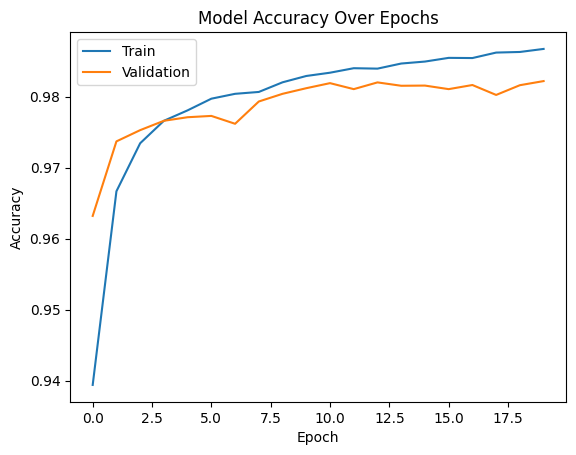

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy

# Set the title and axis labels
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label (Accuracy)
plt.xlabel('Epoch')  # X-axis label (Epoch count)

# Add a legend to differentiate between training and validation accuracy
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')

# Display the plot
plt.show()


### Evaluating the Model on Test Data

After training, the model's performance is **evaluated on the test dataset** using the `model.evaluate()` function.


In [24]:
# Evaluate the trained model on the test dataset
score = model.evaluate(test_x, y_test)

# Print the test loss
print(f'Test Loss: {score[0]:.4f}')  # Display test loss with 4 decimal precision

# Print the test accuracy
print(f'Test Accuracy: {score[1] * 100:.2f}%')  # Convert accuracy to percentage for better readability

1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9806 - loss: 0.0567
Test Loss: 0.0544
Test Accuracy: 98.16%


### Confusion matrix and classification report

1185/1185 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


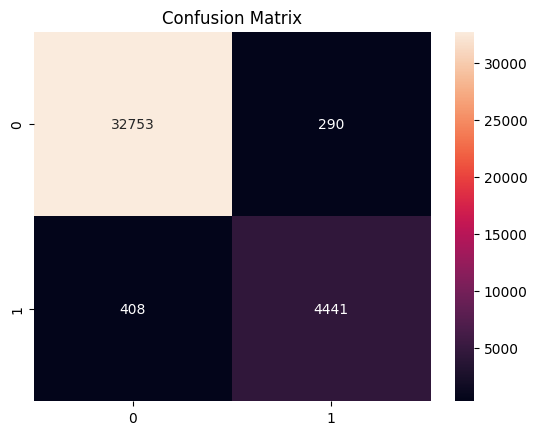

In [25]:
prediction_proba=model.predict(X_test)
prediction = (prediction_proba > 0.5).astype(int)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_test, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d',ax=ax)
ax.set_title('Confusion Matrix'); 
plt.savefig('cm')

In [26]:
cf = classification_report(y_test, prediction, digits=4)
print(cf)

              precision    recall  f1-score   support

           0     0.9877    0.9912    0.9895     33043
           1     0.9387    0.9159    0.9271      4849

    accuracy                         0.9816     37892
   macro avg     0.9632    0.9535    0.9583     37892
weighted avg     0.9814    0.9816    0.9815     37892



In [27]:
# Assuming your CSV has a single row of signal values (modify if needed)
sample_signal = data.iloc[0].values  # Extract first row as numpy array
sample_signal = sample_signal[:-1]
sample_signal.shape

(125,)

In [28]:
for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 0 conv1d (11, 1, 16)
layer number 2 conv1d_1 (13, 16, 32)
layer number 4 conv1d_2 (15, 32, 64)
layer number 6 conv1d_3 (17, 64, 128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


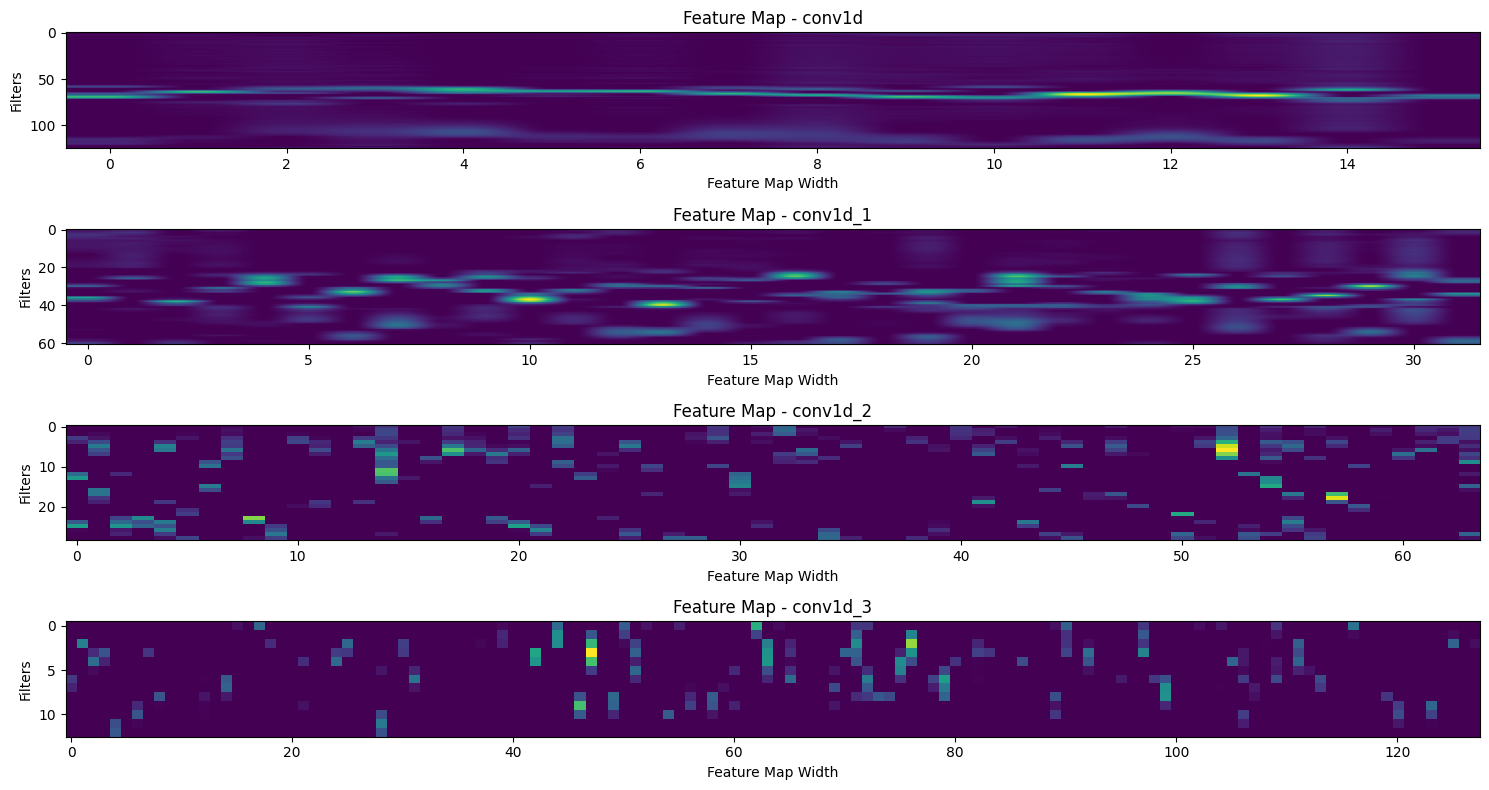

In [29]:
# Reshape data to match model input shape (batch_size=1, time_steps=125, channels=1)
sample_input = np.expand_dims(sample_signal, axis=(0, -1))

# Define a model to extract outputs from convolutional layers
conv_layers = [layer.output for layer in model.layers if 'conv1d' in layer.name]
feature_map_model = Model(inputs=model.inputs, outputs=conv_layers)

# Get feature maps
feature_maps = feature_map_model.predict(sample_input)

# Plot feature maps
layer_names = [layer.name for layer in model.layers if 'conv1d' in layer.name]

plt.figure(figsize=(15, 8))
for i, fmap in enumerate(feature_maps):
    num_filters = fmap.shape[-1]  # Number of filters in this layer
    plt.subplot(len(feature_maps), 1, i + 1)
    plt.imshow(fmap[0, :, :num_filters], aspect='auto', cmap='viridis')
    plt.title(f"Feature Map - {layer_names[i]}")
    plt.xlabel("Feature Map Width")
    plt.ylabel("Filters")
plt.tight_layout()
plt.show()


In [30]:
# def grad_cam(layer_name, data):
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(layer_name).output, model.output]
#     )
#     last_conv_layer_output, preds = grad_model(data)

#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(data)
#         pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     pooled_grads = tf.reduce_mean(grads, axis=(0))

#     last_conv_layer_output = last_conv_layer_output[0]

#     heatmap = last_conv_layer_output * pooled_grads
#     heatmap = tf.reduce_mean(heatmap, axis=(1))
#     heatmap = np.expand_dims(heatmap,0)
#     return heatmap

# layer_name = "conv1d_11"
# for i in X_test:
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data)

#     plt.figure(figsize=(30,4))
#     plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,300,i.min(),i.max()], alpha=0.5)
#     plt.plot(i,'k')
#     plt.colorbar()
#     plt.show()
